# Incremental Analysis of a Shallow Arch

In order to execute this notebook, go to the menu bar and click **Run**/**Run all cells**. You can also run individual cells by selecting the cell (a blue bar will appear to the left of the active cell, then pressing `Shift+Enter`.

> **NOTE** Before running this notebook, you must install the external dependencies.
> To to this, uncomment the following cell by removing the leading `#` character, execute the cell,
> then put the `#` character back to prevent it from running again, thereby "commenting it out". Once everything is installed you may
> re-run the commented-out cell to hide the text generated by the installation.

In [32]:
# !pip install -Ur requirements.txt

<!-- [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/claudioperez/opensees/HEAD?labpath=notebooks%2FIncrementalAnalysis%2FIncrementalAnalysis.ipynb) -->

OpenSees is a finite element analysis platform that is
developed by researchers in the field of earthquake engineering, and made freely available. 
Rather than exposing a graphical user interface like Abaqus or SAP2000, OpenSees can be used directly from several general purpose programming languages. This gives users much greater control for dynamically generating models, conducting an analysis, and performing otherwise cumbersome tasks like topology optimization, reliability studies and training artificial intelligence models.

In this problem, we investigate how this programmatic interface can be used to solve a highly nonlinear problem. Consider the shallow arch shown below (Clarke and Hancock, 1990):

![Shallow arch](./images/ClarkeHancock.png)

This problem exhibits several critical points along the solution path,
and requires the use of a sophisticated algorithm to properly traverse these.
Most finite element analysis programs do not implement algorithms that are capable of solving such problems, so in this study, we will investigate how you can implement one yourself.

We will perform the analysis by creating an OpenSees `Model` data structure, and using
its "methods" to perform various tasks. A "method" is simply a function that
is linked to a particular instance of a data structure. In this case, the `Model`
data structure holds the geometry and state (i.e., the current values of solution variables) of our structural model. Some methods that you might see being used in this notebook include (you wont need to make any changes to the use of any of these):

- `Model.integrator(...)` This method configures the iteration strategy to be performed
  in the next increment
- `Model.analyze(n)` This method applies `n` increments, and between each increment, performs Newton-Raphson iterations.

In this notebook, the `Model` data structure is created by the `arch_model` helper function, which we load from the file [`arch.py`](./arch.py):

In [18]:
from arch import arch_model

We'll also find the following imports convenient:

In [19]:
import numpy as np
from numpy import sign
from numpy.linalg import det

## Solution Strategy

Our general strategy is implemented in the following function `solve()`.
This function adopts an incremental approach
where the load is applied in small steps of varying size. 
The arguments to the function are:

- `model`: an OpenSees `Model` object
- `node` : an integer indicating which node to collect results from.

Both of these arguments will be supplied by the `arch_model` helper function mentioned
above.


In [20]:
def solve(model, node):
    # Initialize some variables
    xy = []      # Container to hold solution history (i.e., load factor and displacement at `node`)
    status = 0   # Convergence flag; Model.analyze() will return 0 if successful.
    data =  1.0  # Explained below
    ds = 45      # Initial arc-length increment
    steps = 110  # Number of steps

    # Configure the first load increment strategy; explained below
    increment(model, ds, data)

    for step in range(steps):

        # 1. Perform Newton-Raphson iterations until convergence for 1 load
        #    increment
        status = model.analyze(1)

        # 2. Store the displacement and load factor
        xy.append([model.nodeDisp(node, 2), model.getTime()])

        # 3. If the iterations failed, try cutting
        #    the increment arc-length in half
        if status != 0:
            ds /= 2

        # 4. Compute new arc-length for the next increment;
        #    Explained below
        ds, data = increment(model, ds, data)

    return np.array(xy).T

## Problem Statement

Each time the load is incremented, the `analyze()` method of the model is invoked
and Newton-Raphson iterations are performed 
to find the displacements which equilibriate the current load. 
Each increment is configured by the following function `increment()` which takes the
following arguments:

- `ds` The initial arc-length increment for the *last* load step
- `det_past` A history variable

The function additionally returns the following variables:

- `ds` the initial arc-length increment for the *upcoming* load step, which is currently the same as the input.
- `det_pres` An update to the history variable, which is currently the same as the input.


In [28]:
def increment(model, ds, det_past):
    # Make your changes here
    det_pres = 1.0
    ds       = ds

    # No changes are needed beyond this point
    model.integrator("ArcLength", ds, 0, exp=0.0)
    return ds, det_pres


In order to pass through critical points, the "Arc-length" method is used to adapt the
load increment at each iteration. However, if you run the notebook as-is, you will find that the algorithm is unable to pass over the first critical point. Note how the displacement begins oscillating in **Plot 2** below.

To circumvent this issue, we propose implementing Crisfield's strategy
for determining the loading direction of the increment.
To this end you are asked to do the following:

> Modify the `increment()` function to detect whether the sign (i.e., `+` or `-`) of the determinant
> of the stiffness has changed since the last time `increment` was invoked. If the
> determinant sign has changed, switch the sign of `ds` and return its modified version.
>
> **Hint**: You can use the `Model.getTangent()` method to obtain the current stiffness matrix, for example:
> ```python
> K = model.getTangent()
> ```
> This will return an array `K` which can be passed to the `det` function that was imported earlier. For documentation of `det`, see https://numpy.org/doc/stable/reference/generated/numpy.linalg.det.html


To check your changes, run all the cells of the notebook and verify that the generated **Plot 1** produces the response
shown in the figure below. When **Plot 1** looks correct, you can export the notebook as a PDF for your submission by going to **File**/**Save and Export Notebook As**/**Webpdf**.

<figure>
    <img src="./7920.jpg">
    <caption><b>Figure</b> Expected response curve</caption>
</figure>


## Analysis

The remainder of this notebook performs the analysis and plots the results.

In [29]:
# create the model
model, mid_node = arch_model()
# run the analysis
x, y = solve(model, mid_node)

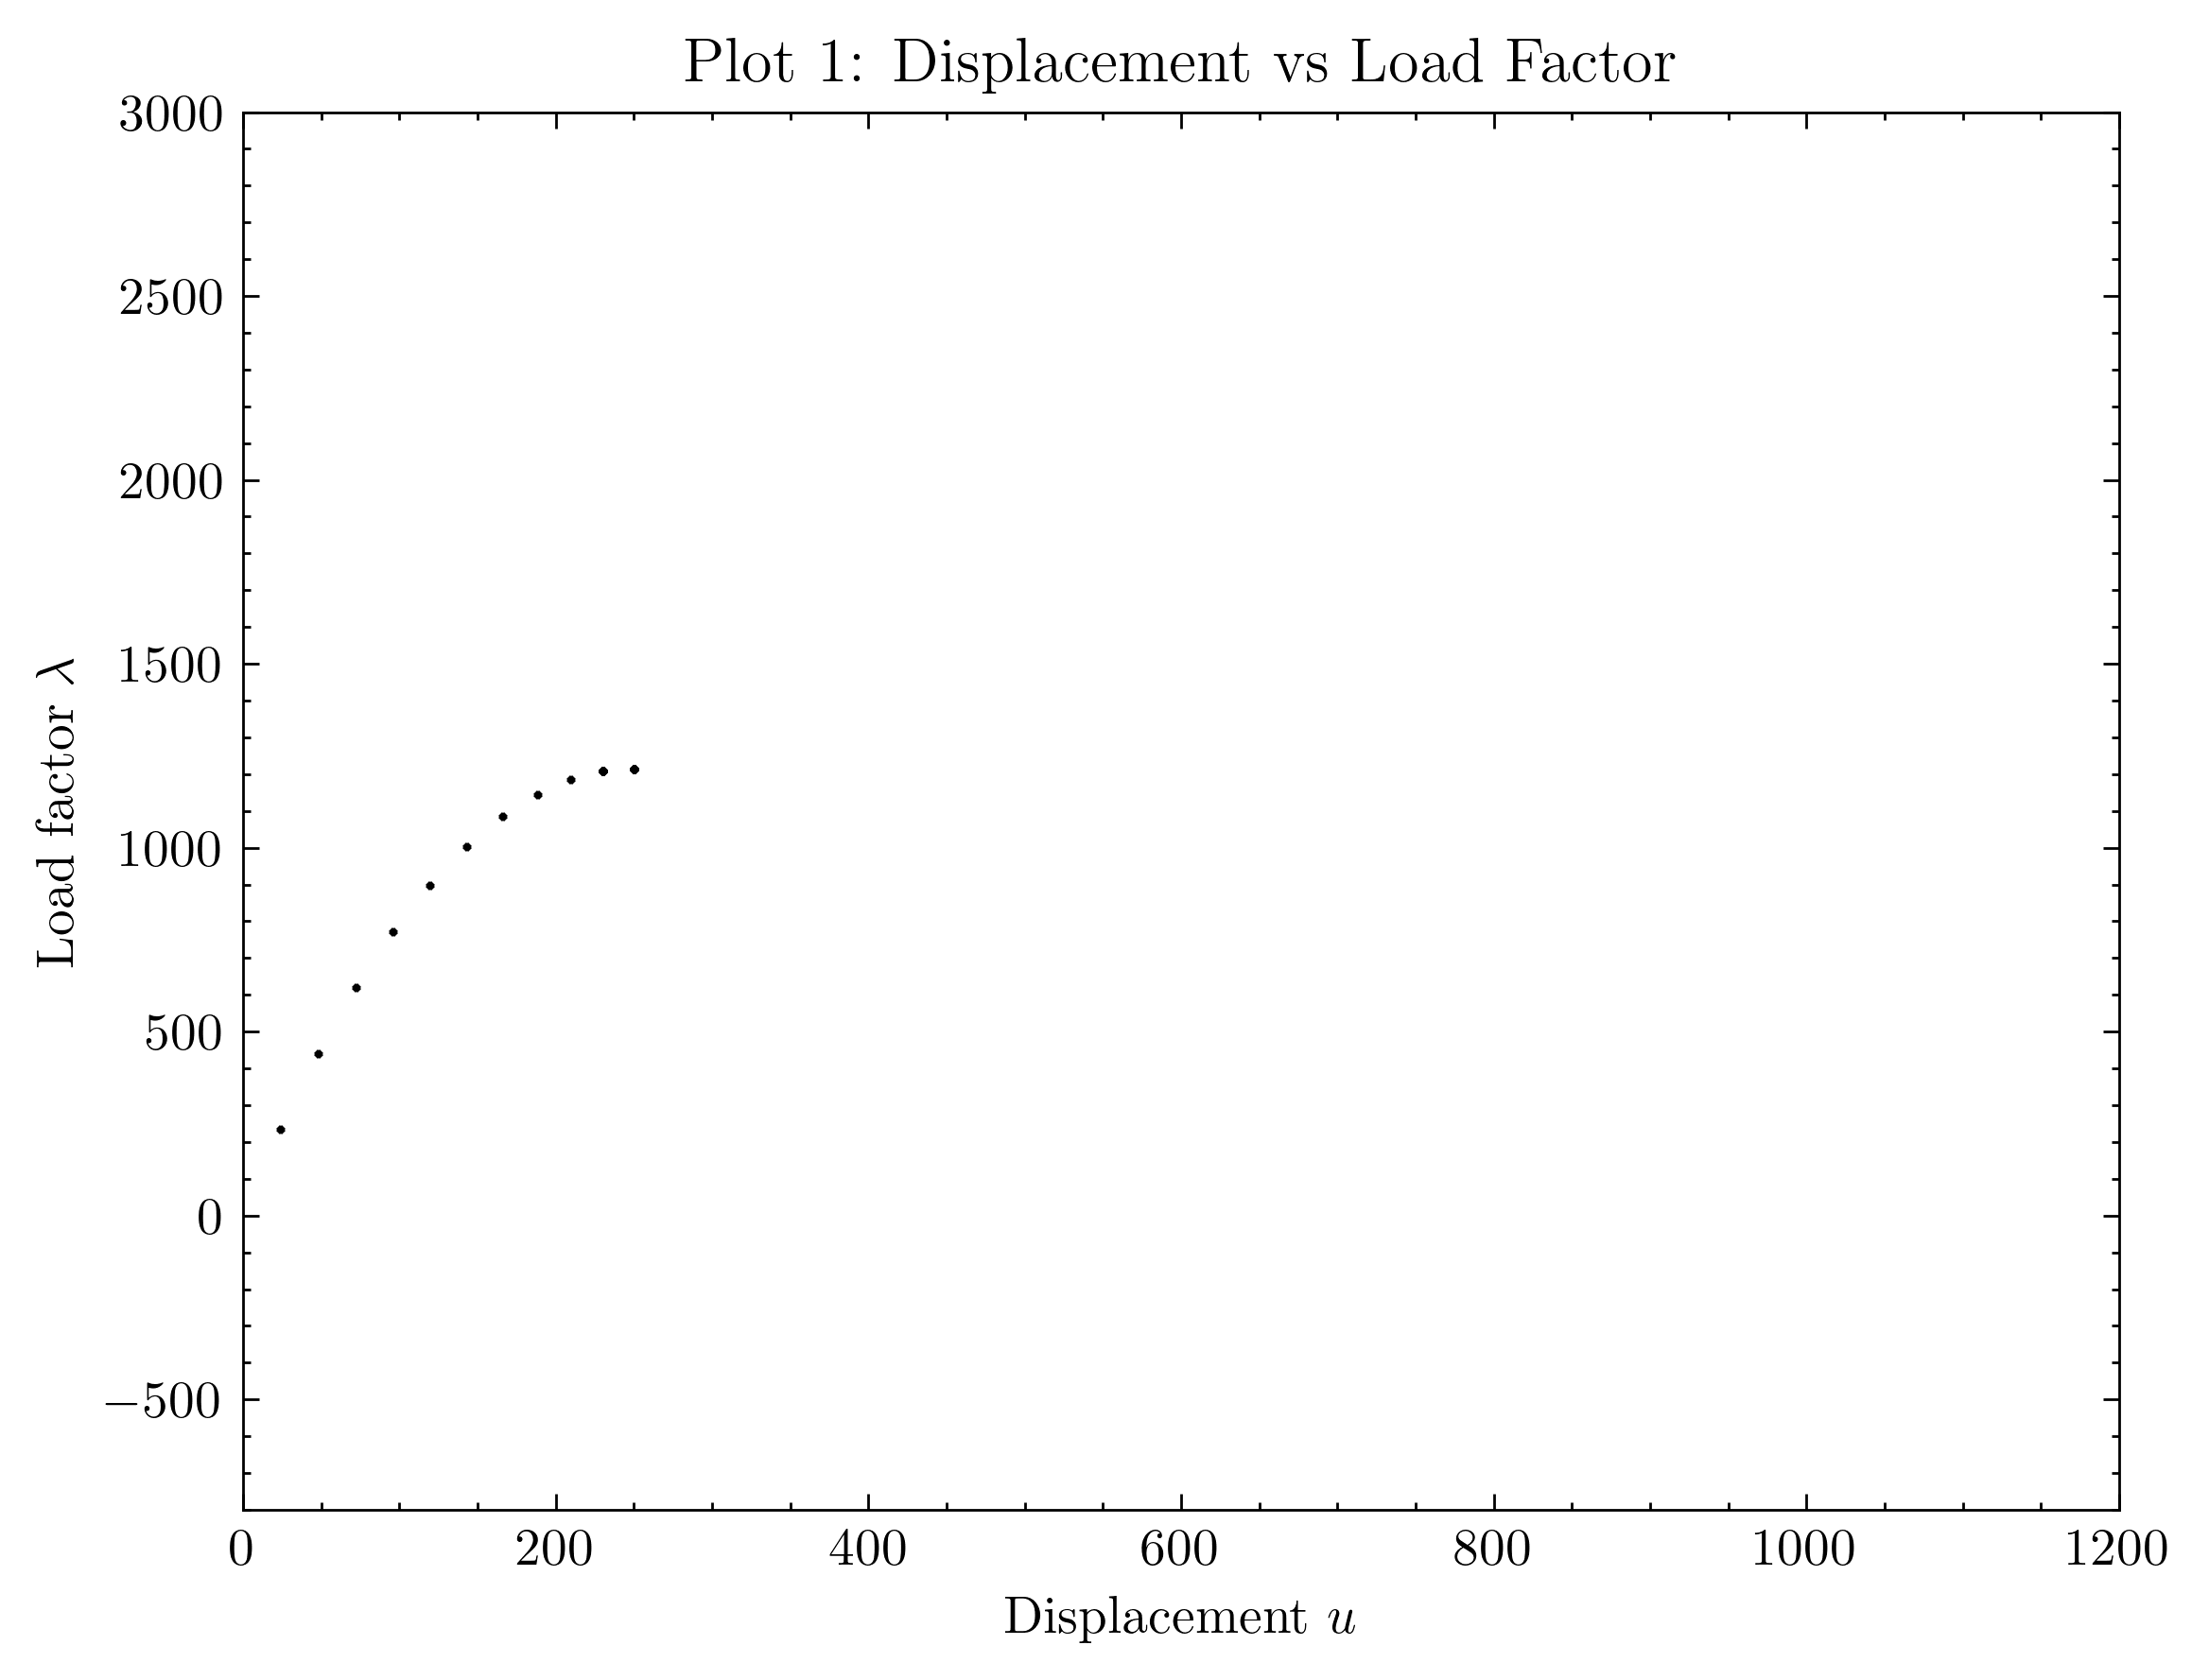

In [30]:
import matplotlib.pyplot as plt

try:
    import scienceplots
    plt.style.use("steel")#["ieee", "science", "notebook"])
except:
    pass
    
fig, ax = plt.subplots()

ax.plot(-x, y, "x")
ax.set_title("Plot 1: Displacement vs Load Factor")
ax.set_ylabel(r"Load factor $\lambda$")
ax.set_xlabel("Displacement $u$")

ax.set_xlim([0, 1200])
ax.set_ylim([-800, 3000]);

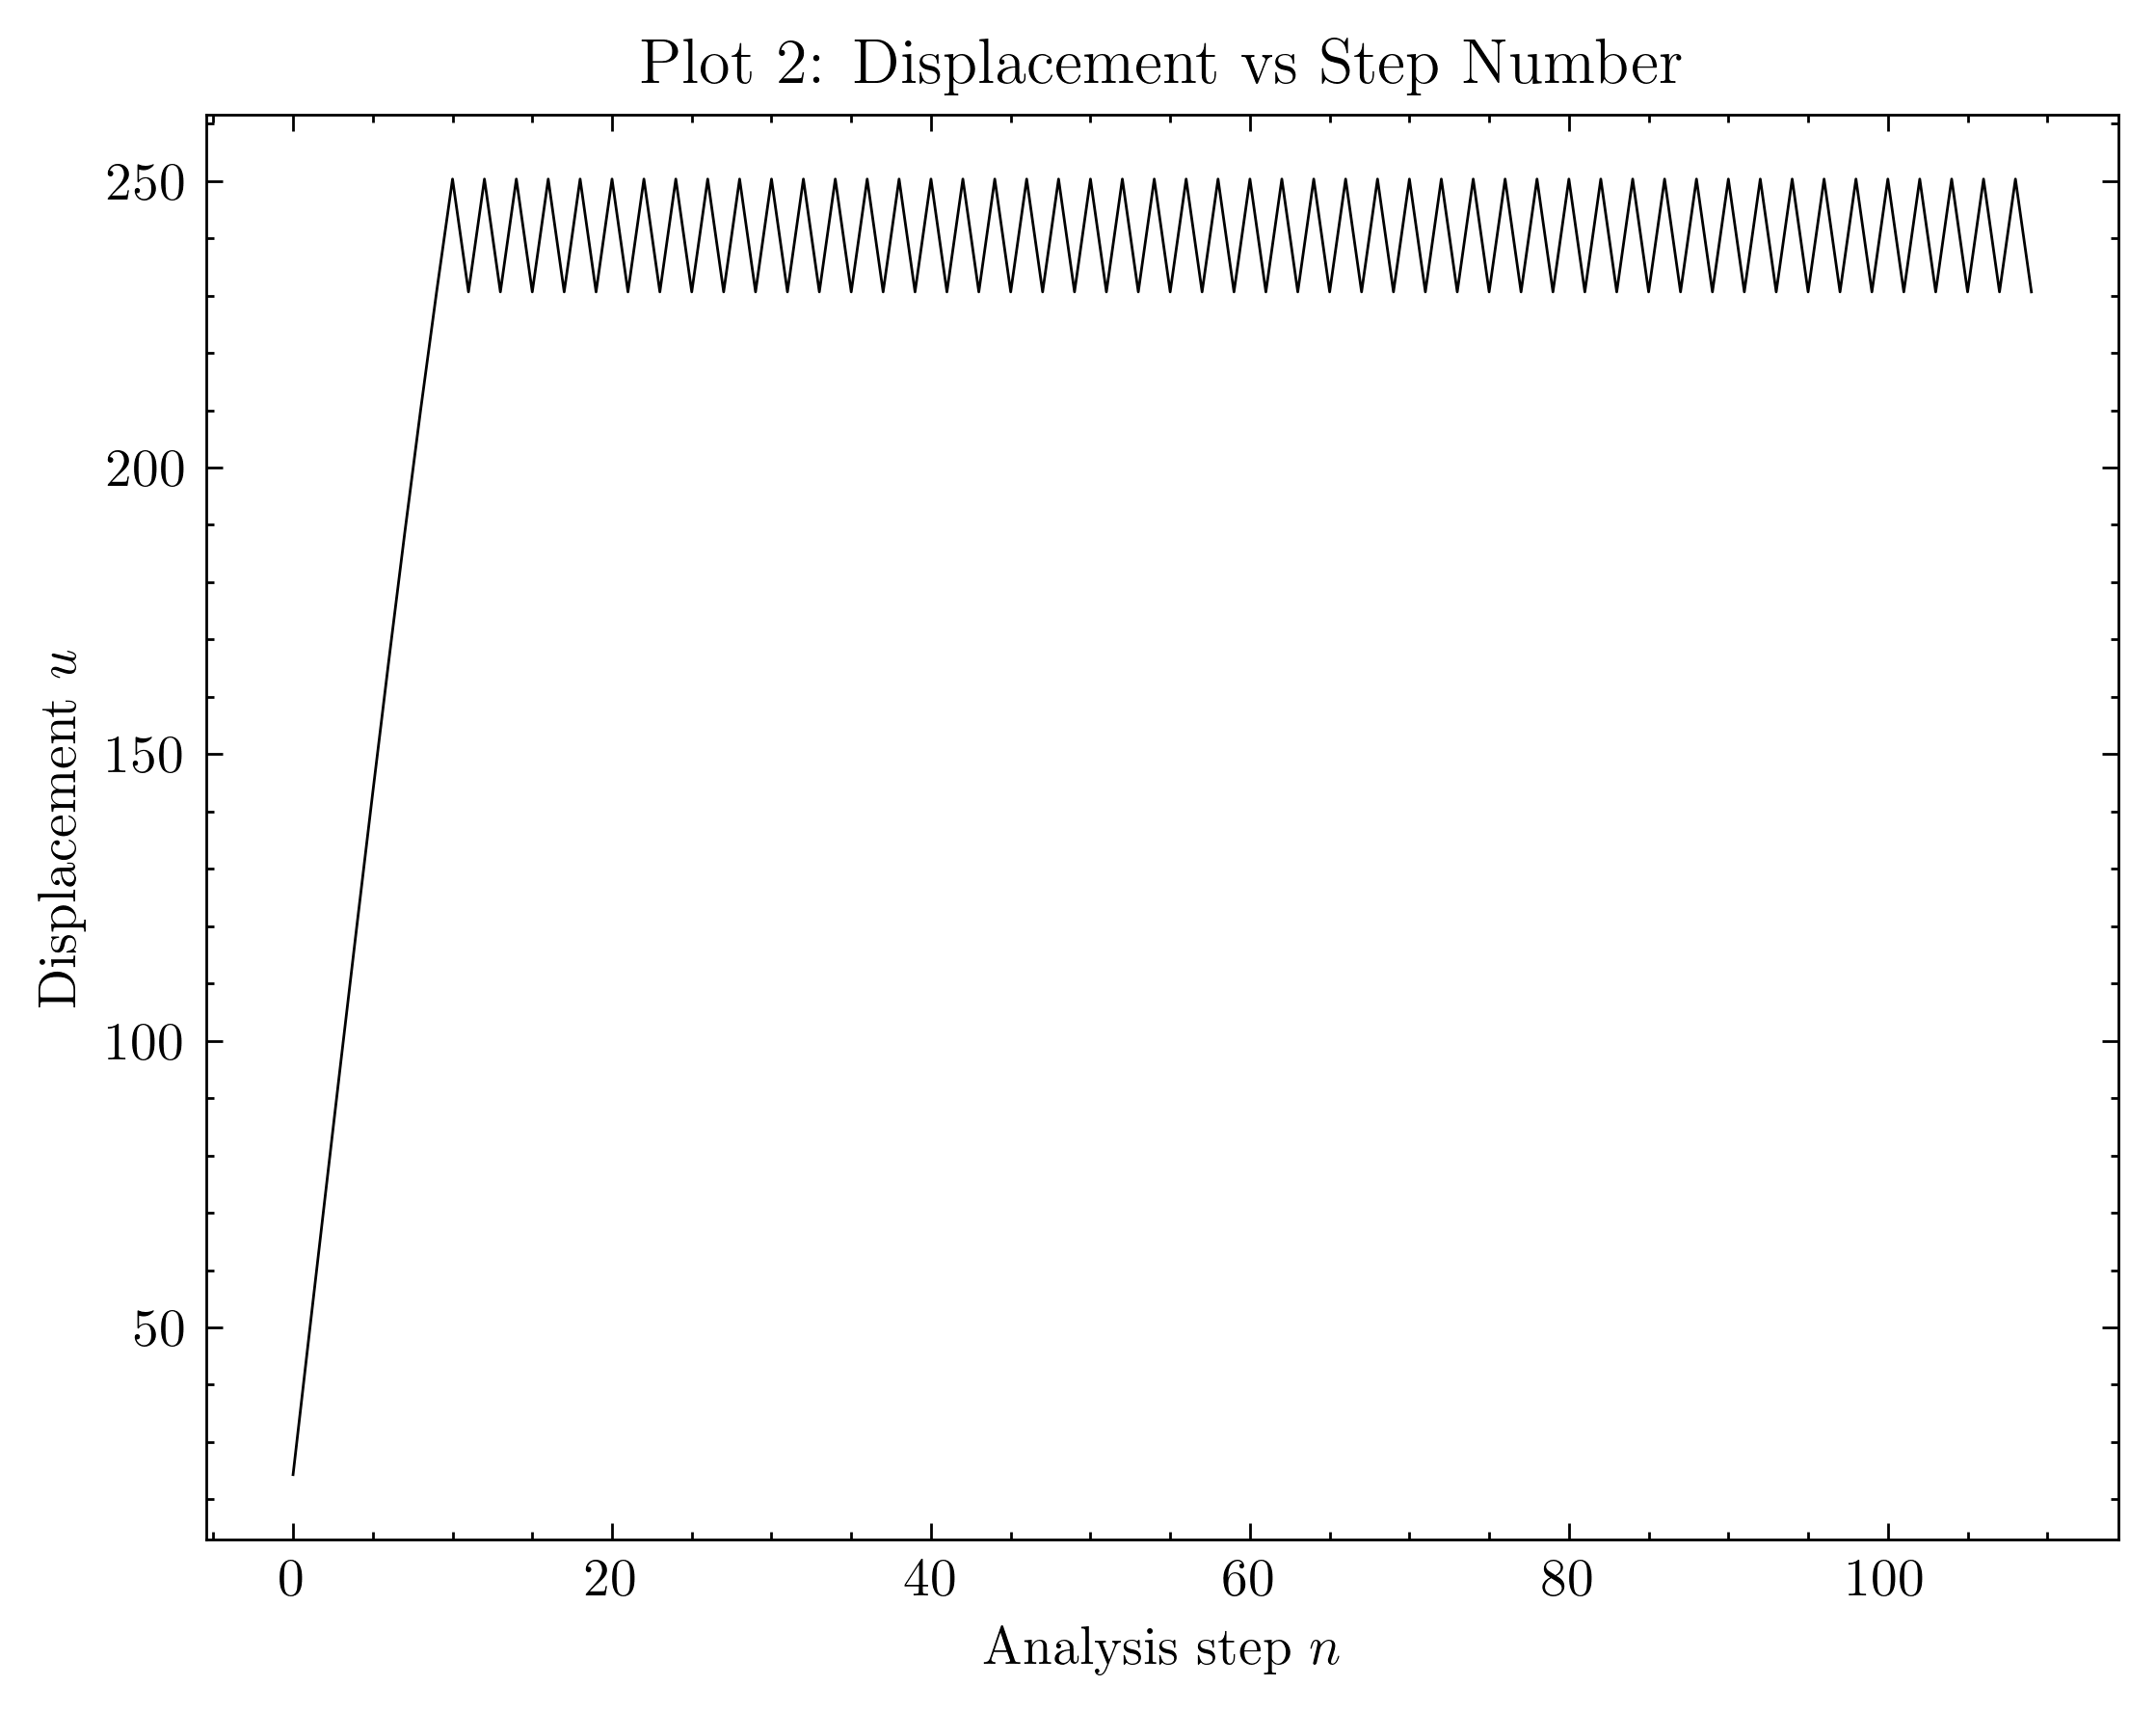

In [31]:
fix, ax = plt.subplots()
ax.plot(-x, '-')
ax.set_title("Plot 2: Displacement vs Step Number")
ax.set_ylabel("Displacement $u$")
ax.set_xlabel("Analysis step $n$");

<!-- ![](./arch.gif) -->

## References

- Clarke, M.J. and Hancock, G.J. (1990) ‘A study of incremental‐iterative strategies for non‐linear analyses’, International Journal for Numerical Methods in Engineering, 29(7), pp. 1365–1391. Available at: https://doi.org/10.1002/nme.1620290702.
